In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
#import sklearn
import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import time
torch.manual_seed(101)

In [2]:
Transform = transforms.ToTensor()

In [3]:
train = datasets.MNIST(root='../Data', train=True, download=True, transform=Transform)
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test = datasets.MNIST(root='../Data', train=False, download=True, transform=Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
image, label = train[0]
print(f'Shape: {image.shape} \nLabel: {label}')

Shape: torch.Size([1, 28, 28]) 
Label: 5


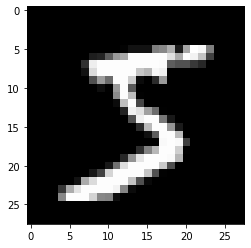

In [6]:
plt.imshow(image.reshape(28,28))
#default color mpa has a purple/yellow/green -> to convert to grayscale add cmap='grey'
plt.imshow(image.reshape(28,28), cmap='gray')

In [7]:
# Load data into batches, If shuffle=train, data will be shuffled on each epoch
train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=500, shuffle=False)

In [8]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120, 84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layers[0])
        self.d2 = nn.Linear(layers[0], layers[1])
        self.d3 = nn.Linear(layers[1], output_size)
    
    def forward(self, X):
        X = F.relu(self.d1(X))
        X = F.relu(self.d2(X))
        X = self.d3(X)
        return F.log_softmax(X, dim=1)
        

In [9]:
model = MultilayerPerceptron()
print(model)

MultilayerPerceptron(
  (d1): Linear(in_features=784, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=84, bias=True)
  (d3): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
for images, labels in train_loader:
    print('Initial batch shape', images.size())
    break
print('Batch shape after flattening ', images.view(100, -1).size())

Initial batch shape torch.Size([100, 1, 28, 28])
Batch shape after flattening  torch.Size([100, 784])


In [13]:
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    # Run the trainining batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        #print(f'Training labels: {y_train.shape}')
        #Apply the model
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        #
        #print(f'Predicted value: {y_pred.shape}, Loss: {loss}')
        #
        # number of correct predictions. Max retuns values & indices. We return the indices.
        predicted = torch.max(y_pred.data, 1)[1]
        #
        batch_corr = (predicted == y_train).sum()        
        trn_corr += batch_corr
        #
        # print(f'Batch correct sum: {batch_corr}, Cumulative training/epoch correct: {trn_corr}')
        #
        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('Parameters updated')
        # print interim result
        if b%600 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f} Train Accuracy: {trn_corr.item()*100/60000:.3f}%')
            
        # update training loss and accuracy for the epoch
        train_losses.append(loss)
        train_correct.append(trn_corr)
        
        # run the testing batches
        #print('Begin, run the testing batches')
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):
                
                #apply the model
                y_val = model(X_test.view(500, -1))
                
                # tally the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1]
                tst_corr += (predicted == y_test).sum()
        #print('End, run the testing batches')
    # update the test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    #
    print(f'Test Accuracy: {test_correct[-1].item()*100/10000:.3f}%')
    

epoch:  0 batch:  600 [ 60000/60000] Train loss: 0.21750157 Train Accuracy: 90.358%
Test Accuracy: 54416.100%
epoch:  1 batch:  600 [ 60000/60000] Train loss: 0.12969886 Train Accuracy: 95.442%
Test Accuracy: 57224.270%
epoch:  2 batch:  600 [ 60000/60000] Train loss: 0.10073543 Train Accuracy: 96.822%
Test Accuracy: 57891.190%
epoch:  3 batch:  600 [ 60000/60000] Train loss: 0.03673933 Train Accuracy: 97.513%
Test Accuracy: 58187.840%
epoch:  4 batch:  600 [ 60000/60000] Train loss: 0.02897004 Train Accuracy: 98.008%
Test Accuracy: 58346.770%


In [ ]:
#